In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src import crs
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel

# data/apt_all.xlsx
# data/apt_1.xlsx
# data/apt_3.xlsx
# data/apt_4.xlsx
# data/apt_std_nugin_1_3.xlsx

data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


# 단일계약상의 공동설비사용요금은 어떻게 구성이 되는가?

## 1. 전기요금계의 기본구조
- 전기요금계는 기본요금, 전력량요금, 기후환경요금, 연료비조정액, 필수사용량 보장공제로 이루어진다.
- 이로써 계산된 전기요금계에 부가가치세와 전력기반사업기금이 적용되어 최종청구금액이 산정된다.

In [33]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

households_kWh = month_df['usage (kWh)'].sum()
PUBLIC_PERCENTAGE = 30
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart
    
crs.utils.print_apt_info(_month, month_df, APT)

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


## 2. 단일계약 전기요금계의 세부적인 구성

### 1. 아파트 전체 사용량의 평균사용량에 대한 요금 산정

In [34]:
# apt_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '기후환경요금', '연료비 조정액', 'VAT', '전력산업기반기금', '기본요금 + 전력량요금', '최종청구금액'])
apt_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '기후환경요금', '연료비 조정액', 'VAT', '전력산업기반기금', '최종청구금액'])

apt_pd = apt_pd.append(
    pd.Series({
        "기본요금" : apt.basic,
        "전력량요금" : apt.elec_rate,
        "기후환경요금" : apt.env,
        "연료비 조정액" : apt.fuel * -1,
        'VAT': "x",
        '전력산업기반기금': "x",
#         '기본요금 + 전력량요금': "x",
        '최종청구금액': "x",
    }, name="가구 수 곱 적용 전"))
apt_pd = apt_pd.append(
    pd.Series({
        "기본요금" : apt.basic * len(month_df),
        "전력량요금" : apt.elec_rate * len(month_df),
        "기후환경요금" : apt.env * len(month_df),
        "연료비 조정액" : apt.fuel * len(month_df) * -1,
        'VAT': round(calc.elec_bill * 0.1),
        '전력산업기반기금': round(mt.floor(calc.elec_bill * 0.037 * 0.1) * 10),
#         '기본요금 + 전력량요금': apt.basic * len(month_df) + apt.elec_rate * len(month_df),
        '최종청구금액': calc.bill
    }, name="가구 수 곱 적용 후"))

print()
print("1. 단일계약은 아파트 전체 사용량(APT)의 평균사용량 {}kWh에 대한 주택용 고압 요금을 먼저 산정한다.".format(
    apt.kwh
))
print("2. 전기요금계의 기본구성요소인 기본요금, 전력량요금, 환경 기후금, 연료비 조정액에 가구 수({}) 를 곱하여 최종 전기요금계를 산정한다.".format(
    len(month_df)
))

print()

apt_pd


1. 단일계약은 아파트 전체 사용량(APT)의 평균사용량 411kWh에 대한 주택용 고압 요금을 먼저 산정한다.
2. 전기요금계의 기본구성요소인 기본요금, 전력량요금, 환경 기후금, 연료비 조정액에 가구 수(108) 를 곱하여 최종 전기요금계를 산정한다.



,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
가구 수 곱 적용 전,6060,45436,2178,-1233,x,x,x
가구 수 곱 적용 후,654480,4907088,235224,-133164,566363,209550,6439540


### 2. 가구 별 요금 산정

In [46]:
households = calc.households

# households_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '기후환경요금', '연료비 조정액', 'VAT', '전력산업기반기금', '기본요금 + 전력량요금'])
households_pd = pd.DataFrame(columns=['기본요금', '전력량요금', '기후환경요금', '연료비 조정액', 'VAT', '전력산업기반기금', '최종청구금액 (공용부 적용 전)'])

for household in households:
    households_pd = households_pd.append(
        pd.Series({
            "기본요금" : household.basic,
            "전력량요금" : household.elec_rate - household.guarantee,
            "기후환경요금" : household.env,
            "연료비 조정액" : household.fuel * -1,
            'VAT': int(household.vat), 
            '전력산업기반기금': int(household.fund),
#             '기본요금 + 전력량요금': household.basic + household.elec_rate
            '최종청구금액 (공용부 적용 전)': household.elec_bill_vat_fund
        }, name=household.name))

print()
print("1. 가구 별로 주택용 고압 요금제에 의한 각 가구 사용량에 대한 요금 산정을 진행한다.")
print()
households_pd.head()


1. 가구 별로 주택용 고압 요금제에 의한 각 가구 사용량에 대한 요금 산정을 진행한다.



,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액 (공용부 적용 전)
아파트1-101-1002,1260,22201,1340,-759,2404,880,27320
아파트1-101-104,6060,103983,3651,-2067,11163,4130,126920
아파트1-101-1102,730,10913,969,-549,1206,440,13700
아파트1-101-1202,1260,20209,1266,-717,2202,810,25030
아파트1-101-1302,6060,54703,2411,-1365,6181,2280,70270


### 3. 가구 별 요금 수거
#### 단일계약 상에서 아파트 전체 사용요금은 "X 가구 수" 의 과정을 거친다. 그렇기 때문에 특정 가구가 적게 사용했든, 많게 사용했든,  아파트 전체 사용요금은 APT 평균 사용량으로 산정된 가격이 각 가구들에게 분배되어있는 구조로 산정된 요금이다. 그래서 실제 각 가구들이 자신의 사용량만큼의 요금을 계산하는 과정을 수거 과정이라고 명칭했다.

In [70]:
_households_pd = households_pd.rename({"최종청구금액 (공용부 적용 전)": "최종청구금액"}, axis=1)
analysis_pd = pd.concat([apt_pd.loc['가구 수 곱 적용 후'],_households_pd.sum(), apt_pd.loc['가구 수 곱 적용 후'] - 
                         _households_pd.sum()], axis=1).T
analysis_pd.index = ['APT', '세대부', '공용부']

print()
print("1. 가구 별로 산정된 요금(세대부) 만큼을 아파트 전체 사용요금에서 수거해간다.")
print("2. 이 후 나머지가 공동설비사용요금이 된다.")
print()

pd.DataFrame(analysis_pd['최종청구금액'])


1. 가구 별로 산정된 요금(세대부) 만큼을 아파트 전체 사용요금에서 수거해간다.
2. 이 후 나머지가 공동설비사용요금이 된다.



,최종청구금액
APT,6439540
세대부,3798980
공용부,2640560


### 4. 가구 별 공용부 요금 분배

In [81]:
households_pd['최종청구금액 (공용부 적용 후)'] = \
        households_pd['최종청구금액 (공용부 적용 전)'] + (round(analysis_pd.loc["공용부"]['최종청구금액'] / len(month_df)))

households_pd.head()

,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액 (공용부 적용 전),최종청구금액 (공용부 적용 후)
아파트1-101-1002,1260,22201,1340,-759,2404,880,27320,51770
아파트1-101-104,6060,103983,3651,-2067,11163,4130,126920,151370
아파트1-101-1102,730,10913,969,-549,1206,440,13700,38150
아파트1-101-1202,1260,20209,1266,-717,2202,810,25030,49480
아파트1-101-1302,6060,54703,2411,-1365,6181,2280,70270,94720


## 3. 단일계약 공동설비사용요금의 구성
#### 부제 : 전기요금계의 기본구성으로 보며, 각 구성이 공동설비사용량의 percentage에 따라 어떻게 달라지는 지 확인해보자
##### 실제 공동설비사용요금은 전기요금계의 기본구성으로 계산이 되어지지 않으며, 단지 가구들이 수거해간 후의 나머지가 되는 형태이다. 이는 세대부가 세부적으로 수거해갔을 때의 공동설비사용요금의 전기요금계의 기본구성을 이렇게 띄고 있겠다. 하고 계산한 표로 이루어지는 분석이다.

In [141]:
analysis_pd.loc['세대부 / APT percentage'] = ((analysis_pd.loc['세대부'] / analysis_pd.loc['APT']) * 100).astype(np.float64).round().astype("int")
analysis_pd.loc['공용부 / APT percentage'] = ((analysis_pd.loc['공용부'] / analysis_pd.loc['APT']) * 100).astype(np.float64).round().astype("int")

analysis_pd

,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
APT,654480,4907088,235224,-133164,566363,209550,6439540
세대부,197480,3068820,164805,-93312,334205,123150,3798980
공용부,457000,1838268,70419,-39852,232158,86400,2640560
세대부 / APT percentage,30,63,70,70,59,59,59
공용부 / APT percentage,70,37,30,30,41,41,41


##### 기본요금

In [89]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 10
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

crs.utils.print_apt_info(_month, month_df, APT)
print("\n---------공동설비사용량 {}% 일 때의 요금표---------".format(PUBLIC_PERCENTAGE))
hh_10, anal_10 = crs.utils.get_analysis_df(_month,month_df, APT)
pd.DataFrame(anal_10['기본요금'])

APT : 34,560kWh (평균 사용량: 320kWh)
		4,142,150원
세대부 : 31,104kWh (90%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 3,456kWh (10%) (평균 사용량: 32kWh)
		343,170원

---------공동설비사용량 10% 일 때의 요금표---------


,기본요금
APT,136080
세대부,197480
공용부,-61400
세대부 / APT percentage,145
공용부 / APT percentage,-45


In [260]:
PUBLIC_PERCENTAGE = 20
APT_20 = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
crs.utils.print_apt_info(_month, month_df, APT_20)

print("\n---------공동설비사용량 {}% 일 때의 요금표---------".format(PUBLIC_PERCENTAGE))
hh_20, anal_20 = crs.utils.get_analysis_df(_month,month_df, APT_20)
pd.DataFrame(anal_20['기본요금'])

APT : 38,880kWh (평균 사용량: 360kWh)
		4,852,400원
세대부 : 31,104kWh (80%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 7,776kWh (20%) (평균 사용량: 72kWh)
		1,053,420원

---------공동설비사용량 20% 일 때의 요금표---------


,기본요금
APT,136080
세대부,197480
공용부,-61400
세대부 / APT percentage,145
공용부 / APT percentage,-45


#### 공동설비사용량 10% -> 20% 증가 시, 각 구성요소들의 변화 및 분석 결과

- 변화하지 않았다.
- 기본요금은 요금 산정에 사용되는 사용량의 누진단계에 따라 고정되는 값이기 때문에 아파트 전체 사용량의 평균 사용량인 320kWh는 공동설비사용량이 20%로 늘어나면서 360kWh가 되었는데, 똑같은 누진 2단계이기 때문에 똑같은 값을 보여줬다.

In [100]:
PUBLIC_PERCENTAGE = 30
APT_30 = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
crs.utils.print_apt_info(_month, month_df, APT_30)

print("\n---------공동설비사용량 {}% 일 때의 요금표---------".format(PUBLIC_PERCENTAGE))
hh_30, anal_30 = crs.utils.get_analysis_df(_month,month_df, APT_30)
pd.DataFrame(anal_30['기본요금'])

APT : 51,840kWh (평균 사용량: 480kWh)
		8,243,530원
세대부 : 31,104kWh (60%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 20,736kWh (40%) (평균 사용량: 192kWh)
		4,444,550원

---------공동설비사용량 40% 일 때의 요금표---------


,기본요금
APT,654480
세대부,197480
공용부,457000
세대부 / APT percentage,30
공용부 / APT percentage,70


In [122]:
public_chk = pd.DataFrame(columns=['공용부 percentage', '공용부 kWh', 'APT 기본요금', '세대부 기본요금', '공용부 기본요금'])

for mean_public_kWh in range(20, 200):
    households_kWh = month_df['usage (kWh)'].sum()
    APT_TEST = households_kWh
    public_kWh = mean_public_kWh * len(month_df)

    mean_households_kWh = round(month_df['usage (kWh)'].mean())
    mean_APT_kWh = round(APT_TEST / len(month_df))
    
    APT_TEST = (mean_APT_kWh + mean_public_kWh) * len(month_df)
    
    hh_test, anal_test = crs.utils.get_analysis_df(_month,month_df, APT_TEST)
    
    public_chk = public_chk.append({
        "공용부 percentage": round(mean_public_kWh / mean_APT_kWh * 100),
        "공용부 kWh": mean_public_kWh,
        "APT 기본요금": anal_test.loc['APT']['기본요금'],
        "세대부 기본요금": anal_test.loc['세대부']['기본요금'],
        "공용부 기본요금": anal_test.loc['공용부']['기본요금']
    }, ignore_index=True)

public_chk

,공용부 percentage,공용부 kWh,APT 기본요금,세대부 기본요금,공용부 기본요금
0,7,20,136080,197480,-61400
1,7,21,136080,197480,-61400
2,8,22,136080,197480,-61400
3,8,23,136080,197480,-61400
4,8,24,136080,197480,-61400
...,...,...,...,...,...
175,68,195,654480,197480,457000
176,68,196,654480,197480,457000
177,68,197,654480,197480,457000
178,69,198,654480,197480,457000


In [115]:
for col in public_chk[['공용부 percentage', '공용부 kWh']]:
    public_chk[col] = (public_chk[col] - public_chk[col].min()) / (public_chk[col].max() - public_chk[col].min())

In [123]:
max_rate = public_chk[['APT 기본요금', '세대부 기본요금', '공용부 기본요금']].max().max()
min_rate = public_chk[['APT 기본요금', '세대부 기본요금', '공용부 기본요금']].min().min()

for col in public_chk[['APT 기본요금', '세대부 기본요금', '공용부 기본요금']]:
    public_chk[col] = (public_chk[col] - min_rate) / (max_rate - min_rate)

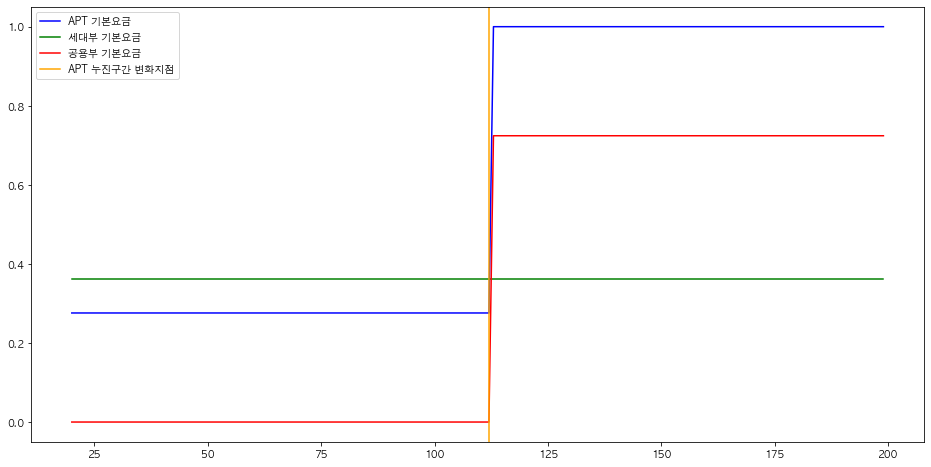

In [132]:
plt.figure(figsize=(16,8))

plt.plot(public_chk['공용부 kWh'], public_chk['APT 기본요금'], color='b', label="APT 기본요금")
plt.plot(public_chk['공용부 kWh'], public_chk['세대부 기본요금'], color='g', label="세대부 기본요금")
plt.plot(public_chk['공용부 kWh'], public_chk['공용부 기본요금'], color='r', label="공용부 기본요금")
plt.axvline(400 - (households_kWh / len(month_df)), color='orange', label='APT 누진구간 변화지점')

plt.legend()
plt.show()

이와 같이, 30% 구간에서는 아파트 전체 사용량의 평균 사용량이 411kWh로 요금 산정에 사용되는 사용량의 누진 단계가 3단계이기 때문에 기본요금의 요금이 변화했다.
- 여기서 특이한 점은, 10%와 20% 데이터를 보면, 세대부에서 수거해가는 기본요금이 더 많았지만, 30% 데이터부터는 공용부의 기본요금이 많이 오르면서, 세대부에서 많이 수거해가지 못했다.
##### 이는 아파트 세대부의 가구 사용량 구성에 따라 달라진다.

In [320]:
basic_conf = pd.DataFrame(hh_30['기본요금'].groupby(hh_30['기본요금']).count())
basic_conf.columns = ['가구 수']
basic_conf.reset_index(inplace=True)
basic_conf.index = ["누진 {}단계".format(idx + 1) for idx,_ in enumerate(basic_conf.index)]
basic_conf

,기본요금,가구 수
누진 1단계,730,20
누진 2단계,1260,73
누진 3단계,6060,15


- 해당 아파트의 가구 사용량 구성을 누진단계에 따라 나누어 보면 위와 같다.
- 10%, 20%에서의 APT 평균 사용량은 누진 2단계에 속해있기 때문에 기본요금이 1260원으로 산정된다.
    - 이 때, 기본요금을 수거해가는 가구들 중 730원으로 수거해가는 가구도 있지만, 6060원을 수거해가는 가구도 있다. 1260원과 730원의 차이에 비해, 1260원과 6060원의 차이는 엄청나다. 때문에, 누진 3단계의 가구가 속해 있다면, APT의 평균사용량이 누진 3단계를 기록하지 않는 이상 세대부가 수거해가는 양이 아파트 전체 사용요금 산정의 기본요금보다 많을 것이며, 이로써 공용부 기본요금이 음수(-)의 형태를 나타나게 된다.
- 30%에서의 APT 평균 사용량은 누진 3단계에 속해있기 때문에 기본요금이 6060원으로 산정된다.
    - 6060원을 완전히 수거해 갈 수 있는 가구는 누진 3단계의 가구 밖에 없다. 때문에 누진 3단계의 가구가 많은 아파트가 아니라면, 공용부의 기본요금이 양수(+)의 형태를 나타나게 되고, 누진 3단계의 가구 비율이 낮을 수록 공용부의 기본요금은 상승한다.
    
##### 결론적으로 공용부 사용요금 중, 기본요금에 영향을 주는 요소는 아파트 전체 사용량의 평균 사용량이 가지는 누진단계와 가구들의 구성이다.

##### 전력량요금

In [321]:
crs.utils.print_apt_info(_month, month_df, APT_30)
pd.DataFrame(anal_30['전력량요금'])

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (71%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (29%) (평균 사용량: 123kWh)
		2,640,560원


,전력량요금
APT,4907088
세대부,3118820
공용부,1788268
세대부 / APT percentage,64
공용부 / APT percentage,36


- APT 평균사용량 411kWh 에 대한 계산식은 아래와 같다.
    - 누진 1단계 : 73.3 * 200kWh = 14,660
    - 누진 2단계 : 142.3 * 200kWh = 28,460
    - 누진 3단계 : 210.6 * 11kWh = 2,316
        =  45,436 * 108 = 4,907,088 원
- 이는 이와도 같으므로,
    - 누진 1단계 : 73.3 * 200kWh * 108가구 수 = 1,583,280
    - 누진 2단계 : 142.3 * 200kWh * 108가구 수 = 3,073,680
    - 누진 3단계 : 210.6 * 11kWh * 108가구 수 = 250,128
        = 4,907,088 원
        
##### 가구마다 단일계약의 411kWh에 대한 수거가 이루어져야 공용부의 전력량요금은 0원을 유지할 수 있다라는 의미이다.
- 하지만 가구 마다 사용량이 다르고, 제 각기 수거해 가는 양도 다를 것 이다. 많이 사용한 가구는 411kWh보다 많이 수거해 갈 것이며, 적게 사용한 가구는 411kWh보다 적게 수거해 갈 것이다. 각 가구의 사용량 / APT 평균 사용량 을 하면 각 가구별로 수거해간 percentage를 구할 수 있다.
    - 그리고 놀랍게도 이들의 평균이 APT에서 세대부의 사용량이 차지하고 있는 percentage 이다.

In [134]:
crs.utils.print_apt_info(_month, month_df, APT_30)
display(Markdown("**(+) 세대부 평균 수거율 : {}%**".format(
    format(
        round((month_df['usage (kWh)'] / 411).mean() * 100),
        ","
    )
)))

APT : 51,840kWh (평균 사용량: 480kWh)
		8,243,530원
세대부 : 31,104kWh (60%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 20,736kWh (40%) (평균 사용량: 192kWh)
		4,444,550원


**(+) 세대부 평균 수거율 : 70%**

#### 잉여자원
- 각 가구별로 수거해야 하는 아파트전체사용요금이 411kWh라고 쳤을 때, 가구 별로 사용량이 다 다르기 때문에, 누군가는 덜 수거하고, 누군가는 더 수거해갈 것 이다. 이 때, 덜 수거해간 가구의 사용량이 **잉여자원** 이다.
- 이전에 공동설비사용요금은 세대부 산정이 끝난 후에 산정됨으로, 세대부가 끝난 다음의 누진 시작단계가 존재할 것 이다. 라고 예측했지만, 실제로는 아래와 같이 작용을 하겠다라고 생각했다.
    - **411kWh일 때 각 누진 단계별 가구마다 수거해가야 하는 자원**
    - 1단계 : 200kWh 
        - 총 사용량 200kWh 미만인 가구는 "200kWh - 해당 가구 총사용량"이 잉여자원이 된다.
    - 2단계 : 200kWh
        - 총 사용량 200kWh 미만인 가구는 "200kWh"가 잉여자원이된다.
        - 총 사용량 400kWh 미만인 가구는 "400kWh - 해당 가구 총사용량"이 잉여자원이 된다.
    - 3단계 : 11kWh
        - 총 사용량이 400kWh 미만인 가구는 "11kWh"가 잉여자원이 된다.
        - 총 사용량이 411kWh 미만인 가구는 "411kWh - 해당 가구 총사용량"이 잉여자원이 된다.
        - 총 사용량이 411kWh 이상인 가구는 "411kWh - 해당 가구 총 사용량"이 잉여자원이 아닌, 다른 잉여자원들을 채워 줄 세이브포인트가 된다.

In [143]:
surplus = pd.DataFrame(month_df['usage (kWh)'])
surplus.index = month_df['name']

# 1단계 잉여자원
surplus['1단계'] = (surplus['usage (kWh)'] - 200).map(lambda x:
                                                0 if x >= 0 else x * -1)

# 2단계 잉여자원
surplus['2단계'] = (surplus['usage (kWh)'] - 400).map(lambda x:
                                                0 if x >= 0 else # 3단계
                                                x * -1 if x >= -200 else  # 2단계
                                                200 # 1단계
                                               )

# 3단계 잉여자원
surplus['3단계'] = (surplus['usage (kWh)'] - 411).map(lambda x:
                                                x * -1 if x >= 0 else # 3단계
                                                x * -1 if x >= -11 else # 3단계
                                                11 # 2단계, 1단계
                                               )
surplus = surplus[["1단계", "2단계", "3단계"]].copy()
surplus.head()

,1단계,2단계,3단계
name,,,
아파트1-101-1002,0,147,11
아파트1-101-104,0,0,-278
아파트1-101-1102,17,200,11
아파트1-101-1202,0,161,11
아파트1-101-1302,0,0,-44


- 평균사용량보다 더 사용한 가구의 사용량은 마지막 단계에서 잉여자원을 남긴 가구를 채워줄 수 있게된다. 
    - 평균사용량으로 측정된 가격인데, 더 사용해서 본인의 사용량으로 전체사용량에 대한 평균사용량을 더 지불한 식이다. 이로써, 다른 가구의 잉여자원을 채워줄 수 있게된다.

In [144]:
# 잉여자원 구출
_save_point = surplus[surplus['3단계'] <= 0]['3단계'].sum()

save_point = np.array([])
for t in surplus['3단계'].values:
    if t <= 0:
        save_point = np.append(save_point, 0)
    elif _save_point == 0:
        save_point = np.append(save_point, t)
    else: 
        err = _save_point + t

        if err > 0:
            err = _save_point
        else:
            err = t * -1

        save_point = np.append(save_point, t + err)
        _save_point -= err            

surplus['3단계'] = save_point.astype("int")
surplus.head()

,1단계,2단계,3단계
name,,,
아파트1-101-1002,0,147,0
아파트1-101-104,0,0,0
아파트1-101-1102,17,200,0
아파트1-101-1202,0,161,0
아파트1-101-1302,0,0,0


#### 잉여자원과 공동설비사용량
- 이렇게 구해진 각 단계별 잉여자원은 아래와 같다.

In [161]:
sum_surplus = (surplus[['1단계', '2단계', '3단계']].sum())
sum_surplus = pd.DataFrame(sum_surplus)
sum_surplus.columns = ['최종 잉여자원 kWh']
sum_surplus.loc['토탈'] = sum_surplus.sum()
sum_surplus.loc['토탈 / 가구수'] = ((surplus[['1단계', '2단계', '3단계']].sum(axis=0).sum()) / len(month_df)).astype("int")
sum_surplus

,최종 잉여자원 kWh
1단계,1539
2단계,11684
3단계,61
토탈,13284
토탈 / 가구수,123


123

- 재미있는 점은 이렇게 구해진 토탈의 가구 수 평균 사용량이 공동설비사용량 percentage와 같다는 사실이다.

In [370]:
crs.utils.print_apt_info(_month, month_df, APT_30)

display(Markdown("**(+) 잉여자원 사용량 : {}kWh ({}%) (평균 사용량: {}kWh)**".format(
    format(sum_surplus.loc['토탈'][0], ","),
    round(sum_surplus.loc['토탈'][0] / APT_30 * 100),
    (sum_surplus.loc['토탈'] / len(month_df)).values.astype("int")[0]
)))

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


**(+) 잉여자원 사용량 : 13,284kWh (30%) (평균 사용량: 123kWh)**

In [371]:
surplus["1단계"] = surplus["1단계"] * 73.3
surplus["2단계"] = surplus["2단계"] * 142.3
surplus["3단계"] = surplus["3단계"] * 210.6

print("잉여자원 계산요금: {}원".format(
    format(int(surplus.values.sum().round()),",")
))
pd.DataFrame(anal_30['전력량요금'])

잉여자원 계산요금: 1,788,288원


,전력량요금
APT,4907088
세대부,3118820
공용부,1788268
세대부 / APT percentage,64
공용부 / APT percentage,36


##### 결론적으로 공용부 사용요금 중, 전력량요금에 영향을 주는 요소는 기본요금과 같다.
- 특정 누진단계부터 시작하는게 아닌, 가구들 별로 수거해가야 하는 누진 단계의 할당량이 정해져 있는데, 이것들을 다 가지고 가지 못하고, 아파트 전체 사용량 면에서의 관점으로 내려다보면, 수거하지 않은 잉여자원이 발생되어 있다. 이것들의 합이 공용설비사용요금의 전력량요금이 된다.

#### 기본요금과 전력량요금의 차이
- 기본요금과 전력량요금 둘 다 가구의 구성에 따라 크게 달라질 수 있음을 보여줬다.
- 단 한가지 다른점은 기본요금은 누진세에 대한 고정값이라는 점이고, 전력량요금은 누진세에 따라 동적으로 변화하는 값이라는 점 이다.
    - 그래서 공용부의 기본요금은 음수의 값을 가질 수 있지만, 전력량요금은 대부분의 상황에서 음수의 값을 가질 수 없다.
    - 하나의 가구가 Save Point를 발생시켜서, 아파트 전체에서 잉여자원을 가지고 있는 가구들을 모두 구제하려면 엄청나게 많이 사용해야 한다.
        - 아파트 전체 사용량의 평균사용량 1kWh를 구제하려면 (가구 수 - 1)kWh의 Save Point가 필요
    - 공용부에서 기본요금이 음수의 값을 발생시키면, 이는 나중에 공용부 합산치에서 guarantee로 작용이 될 것 이다.
    - 그리고 이 값이 VAT와 전력산업기반기금과 일정한 percentage를 가지고 올라간다.

In [375]:
anal_10[['VAT','전력산업기반기금','기본요금 + 전력량요금']]

,VAT,전력산업기반기금,기본요금 + 전력량요금
APT,364306,134790,3563568
세대부,334205,123150,3316300
공용부,30101,11640,247268
세대부 / APT percentage,92,91,93
공용부 / APT percentage,8,9,7


In [376]:
anal_20[['VAT','전력산업기반기금','기본요금 + 전력량요금']]

,VAT,전력산업기반기금,기본요금 + 전력량요금
APT,426773,157900,4178304
세대부,334205,123150,3316300
공용부,92568,34750,862004
세대부 / APT percentage,78,78,79
공용부 / APT percentage,22,22,21


In [377]:
anal_30[['VAT','전력산업기반기금','기본요금 + 전력량요금']]

,VAT,전력산업기반기금,기본요금 + 전력량요금
APT,566363,209550,5561568
세대부,334205,123150,3316300
공용부,232158,86400,2245268
세대부 / APT percentage,59,59,60
공용부 / APT percentage,41,41,40


##### 환경 기후금, 연료비조정액
- 환경 기후금과 연료비조정액은 누진단계가 존재하지 않는다. 그래서 가구별로 공평하게 자신이 사용한 만큼은 가지고 간다. percentage가 사용량 percentage와 같이 올라간다. 
- 공동설비사용량에 대한 percentage와 같기 때문에, 공정한 액수이다.

In [373]:
crs.utils.print_apt_info(_month, month_df, APT_30)
pd.DataFrame(anal_30[['환경 기후금','연료비 조정액']])

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


,환경 기후금,연료비 조정액
APT,235224,-133164
세대부,164805,-93312
공용부,70419,-39852
세대부 / APT percentage,70,70
공용부 / APT percentage,30,30


## 4. 특정 아파트의 한달 공동설비사용량 평균사용량 1kWh의 증가는 어떤 것을 의미할까?
- 기여도 가격분배를 이행하기 위한 과정이다.
- 기본요금과 전력량요금이 아파트 가구 구성과 관계를 가지고 있다는 것을 우리는 위에서 확인했다. 이 말은 아파트마다 공동설비사용량 1kWh의 의미가 다를 것 이라는 의미이다.
- 실제 공동설비사용량 1kWh의 증가는 너무 미세하므로, 평균사용량 1kWh의 증가로 테스팅 해보겠다.

In [478]:
public_chk = pd.DataFrame(columns=['공용부 percentage', '공용부 kWh','전력량요금'])

for mean_public_kWh in range(20, 200):
    households_kWh = month_df['usage (kWh)'].sum()
    APT_TEST = households_kWh
    public_kWh = mean_public_kWh * len(month_df)

    mean_households_kWh = round(month_df['usage (kWh)'].mean())
    mean_APT_kWh = round(APT_TEST / len(month_df))
    
    APT_TEST = (mean_APT_kWh + mean_public_kWh) * len(month_df)
    
    hh_test, anal_test = crs.utils.get_analysis_df(_month,month_df, APT_TEST)
    
    public_chk = public_chk.append({
        "공용부 percentage": round(mean_public_kWh / mean_APT_kWh * 100),
        "공용부 kWh": mean_public_kWh,
        "전력량요금": anal_test.loc['공용부']['전력량요금']
    }, ignore_index=True)

public_chk

,공용부 percentage,공용부 kWh,전력량요금
0,7,20,124204
1,7,21,139540
2,8,22,154984
3,8,23,170320
4,8,24,185656
...,...,...,...
175,68,195,3425872
176,68,196,3448660
177,68,197,3471448
178,69,198,3494128


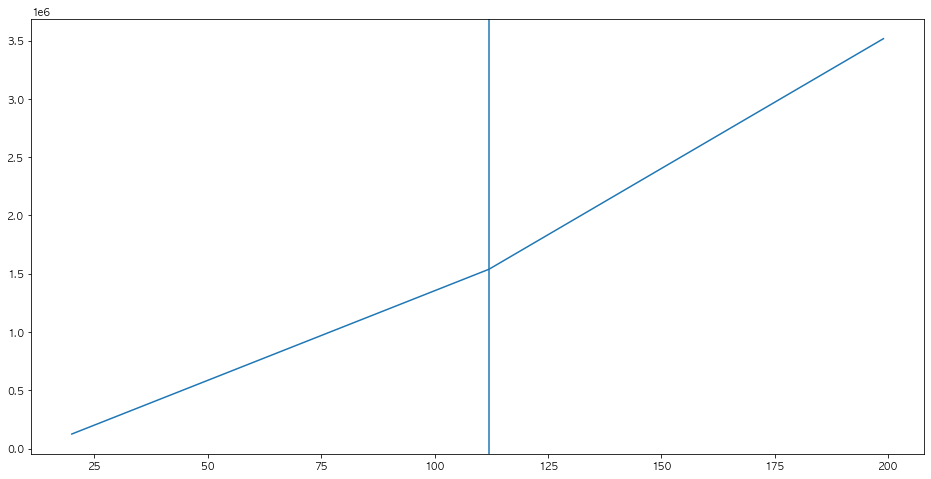

In [479]:
plt.figure(figsize=(16,8))

rolling_chk = public_chk.rolling(3).mean().dropna()
plt.plot(public_chk['공용부 kWh'], public_chk['전력량요금'])
plt.axvline(400 - (households_kWh / len(month_df)))

plt.show()

In [499]:
nugin_2 = 400 - (households_kWh / len(month_df))

public_chk_2 = public_chk[public_chk['공용부 kWh'] <= nugin_2].copy()
public_chk_2['가구 1인당 전력량요금'] = (public_chk_2['전력량요금'] / len(month_df)).astype(np.float64).round().astype("int")
public_chk_2['이전 사용량 오차'] = public_chk_2['가구 1인당 전력량요금'] - np.append(public_chk_2['가구 1인당 전력량요금'].iloc[0], public_chk_2['가구 1인당 전력량요금'].values)[:-1]

display(Markdown("해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **{}원씩** 증가합니다.".format(
    round(public_chk_2['이전 사용량 오차'][1:].mean() * 100) / 100
)))

public_chk_2.head()

해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **142.3원씩** 증가합니다.

,공용부 percentage,공용부 kWh,전력량요금,가구 1인당 전력량요금,이전 사용량 오차
0,7,20,124204,1150,0
1,7,21,139540,1292,142
2,8,22,154984,1435,143
3,8,23,170320,1577,142
4,8,24,185656,1719,142


In [500]:
public_chk_3 = public_chk[public_chk['공용부 kWh'] > nugin_2].copy()
public_chk_3['가구 1인당 전력량요금'] = (public_chk_3['전력량요금'] / len(month_df)).astype(np.float64).round().astype("int")
public_chk_3['이전 사용량 오차'] = public_chk_3['가구 1인당 전력량요금'] - np.append(public_chk_3['가구 1인당 전력량요금'].iloc[0], public_chk_3['가구 1인당 전력량요금'].values)[:-1]

display(Markdown("해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **{}원씩** 증가합니다.".format(
    round(public_chk_3['이전 사용량 오차'][1:].mean() * 100) / 100
)))

public_chk_3.head()

해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **210.6원씩** 증가합니다.

,공용부 percentage,공용부 kWh,전력량요금,가구 1인당 전력량요금,이전 사용량 오차
93,39,113,1560820,14452,0
94,40,114,1583608,14663,211
95,40,115,1606288,14873,210
96,40,116,1629076,15084,211
97,41,117,1651864,15295,211


#### 어디서 많이 본적이 있지 않은가?
- 기타 계절 주택용 고압 요금표
    - 1단계 - 기본요금 (730원) / 1kWh당 요금 (73.3원)
    - 2단계 - 기본요금 (1,260원) / 1kWh당 요금 (142.3원)
    - 3단계 - 기본요금 (6,060원) / 1kWh당 요금 (210.6원)
- 세대부 평균사용량은 288kWh이다. 즉, 누진세 2단계의 적용을 받고 있다.
    - 공용부 평균사용량의 1kWh증가는 세대부 평균사용량이 끝난 후의 단계인 누진세 2단계의 적용을 받고 있었다.
    - 이 후 113kWh이상의 공용부 평균사용량을 보여주게되면, 아파트 전체 평균사용량은 401kWh로, 누진세 3단계의 적용을 받게 된다.
##### 공용부의 전력량요금의 1kWh는 세대부 평균사용량 이후의 누진세 단계가 적용된다. (형평성의 문제)
##### 세대부의 평균사용량 또한 가구들의 구성으로 만들어지는 것이기 때문에, 가구의 구성이 베이스가 되지만 더 직관적으로 공용부 전력량요금을 예측할 수 있게 된 것 이다.
- 이는 아파트 전체 평균 사용량이 1kWh 증가했으므로 당연할 수도 있지만, 공동설비사용량도 특별하지 않은 세대부 위에 쌓인 값이라는 설명이 된다.
- 하지만 특정 아파트의 공용부 요금의 증가율을 최종적으로 결정 짓는 것은 기본요금과 전력량요금이 합쳐진 요금이다.
    - 기본요금은 특정 아파트의 평균 사용량에 따라 고정적으로 값이 고정되며, 가구 구성에 가장 영향을 많이 받는 요소이다.
    - 이도 테스트

In [501]:
public_chk = pd.DataFrame(columns=['공용부 percentage', '공용부 kWh','기본요금 + 전력량요금'])

for mean_public_kWh in range(20, 200):
    households_kWh = month_df['usage (kWh)'].sum()
    APT_TEST = households_kWh
    public_kWh = mean_public_kWh * len(month_df)

    mean_households_kWh = round(month_df['usage (kWh)'].mean())
    mean_APT_kWh = round(APT_TEST / len(month_df))
    
    APT_TEST = (mean_APT_kWh + mean_public_kWh) * len(month_df)
    
    hh_test, anal_test = crs.utils.get_analysis_df(_month,month_df, APT_TEST)
    
    public_chk = public_chk.append({
        "공용부 percentage": round(mean_public_kWh / mean_APT_kWh * 100),
        "공용부 kWh": mean_public_kWh,
        '기본요금 + 전력량요금': anal_test.loc['공용부']['기본요금 + 전력량요금']
    }, ignore_index=True)

public_chk

,공용부 percentage,공용부 kWh,기본요금 + 전력량요금
0,7,20,62804
1,7,21,78140
2,8,22,93584
3,8,23,108920
4,8,24,124256
...,...,...,...
175,68,195,3882872
176,68,196,3905660
177,68,197,3928448
178,69,198,3951128


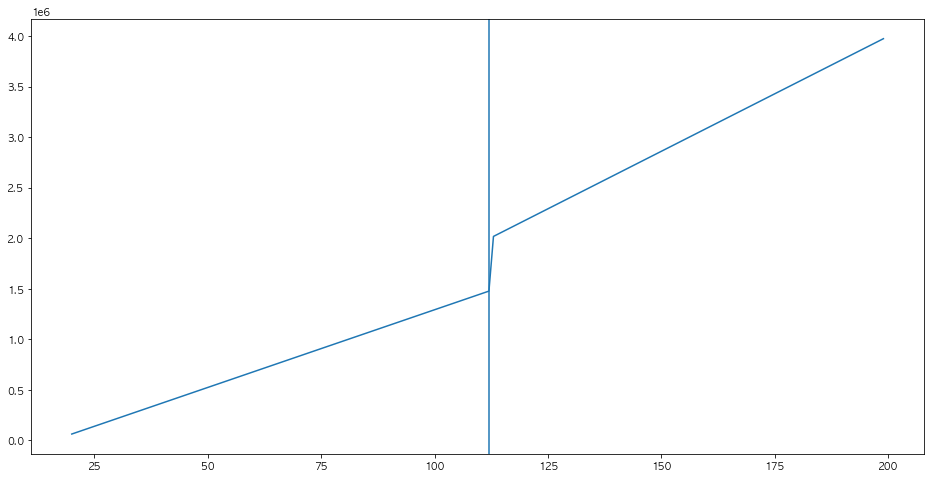

In [507]:
plt.figure(figsize=(16,8))

rolling_chk = public_chk.rolling(3).mean().dropna()
plt.plot(public_chk['공용부 kWh'], public_chk['기본요금 + 전력량요금'])
plt.axvline(400 - (households_kWh / len(month_df)))

plt.show()

In [508]:
nugin_2 = 400 - (households_kWh / len(month_df))

public_chk_2 = public_chk[public_chk['공용부 kWh'] <= nugin_2].copy()
public_chk_2['가구 1인당 기본요금 + 전력량요금'] = (public_chk_2['기본요금 + 전력량요금'] / len(month_df)).astype(np.float64).round().astype("int")
public_chk_2['이전 사용량 오차'] = public_chk_2['가구 1인당 기본요금 + 전력량요금'] - np.append(public_chk_2['가구 1인당 기본요금 + 전력량요금'].iloc[0], public_chk_2['가구 1인당 기본요금 + 전력량요금'].values)[:-1]

display(Markdown("해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **{}원씩** 증가합니다.".format(
    round(public_chk_2['이전 사용량 오차'][1:].mean() * 100) / 100
)))

public_chk_2.head()

해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **142.3원씩** 증가합니다.

,공용부 percentage,공용부 kWh,기본요금 + 전력량요금,가구 1인당 기본요금 + 전력량요금,이전 사용량 오차
0,7,20,62804,582,0
1,7,21,78140,724,142
2,8,22,93584,867,143
3,8,23,108920,1009,142
4,8,24,124256,1151,142


In [510]:
public_chk_3 = public_chk[public_chk['공용부 kWh'] > nugin_2].copy()
public_chk_3['가구 1인당 기본요금 + 전력량요금'] = (public_chk_3['기본요금 + 전력량요금'] / len(month_df)).astype(np.float64).round().astype("int")
public_chk_3['이전 사용량 오차'] = public_chk_3['가구 1인당 기본요금 + 전력량요금'] - np.append(public_chk_3['가구 1인당 기본요금 + 전력량요금'].iloc[0], public_chk_3['가구 1인당 기본요금 + 전력량요금'].values)[:-1]

display(Markdown("해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **{}원씩** 증가합니다.".format(
    round(public_chk_3['이전 사용량 오차'][1:].mean() * 100) / 100
)))

public_chk_3.head()

해당 아파트에서는 공용부 평균사용량이 1kWh 증가할 때, 전력량요금은 평균적으로 **210.6원씩** 증가합니다.

,공용부 percentage,공용부 kWh,기본요금 + 전력량요금,가구 1인당 기본요금 + 전력량요금,이전 사용량 오차
93,39,113,2017820,18684,0
94,40,114,2040608,18895,211
95,40,115,2063288,19105,210
96,40,116,2086076,19316,211
97,41,117,2108864,19527,211


#### 똑같다! 증가의 관점으로는!!!
##### 그래도 이 증가율이 큰 도움이 될 것이다. 흐흐흐,,,허;;